<a href="https://colab.research.google.com/github/mcagriaksoy/pollen_multi_class_ai/blob/main/Pollen_classification_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mehmet Cagri Aksoy . 2024
#github.com/mcagriaksoy

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Datasets/Pollen/Pollen_Dataset.zip

In [ ]:
CLASS_NUMBER = 116
channels = 3
img_height = 50
img_width = 50
epochs = 50
batch_size = 64

input_shape = (img_height,img_width,channels)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# We'll build the CNN as a sequence of layers.
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
# Libraries to handle the data
import json
from PIL import Image # PIL = Python Image Library
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


In [ ]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:
train_Datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #horizontal_flip=True,
    #vertical_flip=True,
    #rotation_range=20,
    #brightness_range=(0.8,1.2),
    #zoom_range = [1, 1.2],
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #preprocessing_function=add_noise,
    validation_split=0.25
)

dir = '/content/train'

train_dataset = train_Datagen.flow_from_directory(batch_size=batch_size,
                                                 directory=dir,
                                                 shuffle=False,
                                                 target_size=(img_height,img_width),
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = train_Datagen.flow_from_directory(batch_size=batch_size,
                                                 directory=dir,
                                                 shuffle=False,
                                                 target_size=(img_height,img_width),
                                                 subset="validation",
                                                 class_mode='categorical')


Found 16203 images belonging to 116 classes.
Found 5327 images belonging to 116 classes.


In [ ]:
train_classes = train_dataset.classes

In [ ]:
train_dataset.class_indices

{'100_prunus': 0,
 '101_populus': 1,
 '102_platanus': 2,
 '103_fraxinus': 3,
 '104_dactylis': 4,
 '105_corylus': 5,
 '106_carpinus_betulus': 6,
 '107_brassica_napus': 7,
 '108_betula': 8,
 '109_anthoxanthum-grass': 9,
 '10_olea': 10,
 '110_alnus': 11,
 '111_aesculus-carnea': 12,
 '112_acer_pseudoplatanus': 13,
 '113_archontophoenix_cunninghamiana': 14,
 '114_brugmansia_suaveolens': 15,
 '115_mimosa_ditrans': 16,
 '116_schizolobium_parahyba': 17,
 '117_not_polen': 18,
 '11_origanum': 19,
 '12_oxalis': 20,
 '13_pinus_nigra': 21,
 '14_pistacia': 22,
 '15_salvia': 23,
 '16_satureja': 24,
 '17_sinapis': 25,
 '18_thymbra': 26,
 '19_urginea': 27,
 '1_asphodelus': 28,
 '20_vitis': 29,
 '21_acacia_plumosa': 30,
 '22_acrocomia_aculeta': 31,
 '23_anadenanthera_colubrina': 32,
 '24_arachis_sp': 33,
 '25_arecaceae': 34,
 '26_arrabidaea_florida': 35,
 '27_aspilia_grazielae': 36,
 '28_bacopa_australis': 37,
 '29_caesalpinia_peltophoroides': 38,
 '2_calicotome': 39,
 '30_caryocar_brasiliensis': 40,
 '

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))

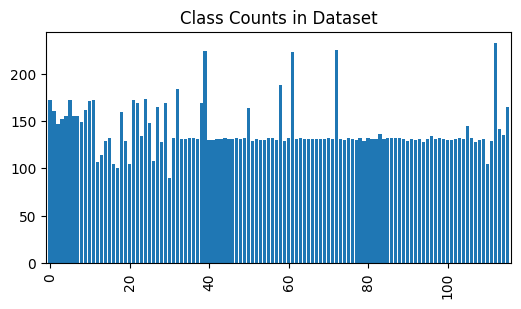

In [ ]:
from collections import Counter
counter = Counter(train_dataset.classes)

plt.figure(figsize = (6,3))
plt.title('Class Counts in Dataset')
plt.bar(*zip(*counter.items()))
plt.xlim([-1,len(class_weights)])
plt.xticks(rotation='vertical')
plt.show()

**Jax**

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, include_top = False, weights = "imagenet")
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.1),
                             tf.keras.layers.Dense(CLASS_NUMBER, activation="softmax")
                            ])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 116)               148596    
                                                                 
Total params: 2406580 (9.18 MB)
Trainable params: 148596 (580.45 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(
    #learning_rate = 0.001
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'densenet_yeni_Deneme.h5'
callback = [EarlyStopping(monitor ='val_loss', patience = 5), reduce_lr,
             ModelCheckpoint(filepath = model_path, save_best_only = True, mode='min', verbose=1)]

In [ ]:
from keras.models import load_model

#Reload model
model = load_model('/content/densenet_yeni_Deneme.h5')

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [ ]:
model.fit(
    train_dataset,
    steps_per_epoch = train_dataset.samples // batch_size,
    validation_data = validation_dataset,
    validation_steps = validation_dataset.samples // batch_size,
    epochs = epochs,
    class_weight = class_weights,
    callbacks = callback
    )

Epoch 1/50
253/253 [==============================] - ETA: 0s - loss: 5.6292 - accuracy: 0.0496
Epoch 1: val_loss improved from inf to 3.08673, saving model to densenet_yeni_Deneme.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


253/253 [==============================] - 73s 286ms/step - loss: 5.6292 - accuracy: 0.0496 - val_loss: 3.0867 - val_accuracy: 0.2344 - lr: 0.0010
Epoch 2/50
253/253 [==============================] - ETA: 0s - loss: 2.9751 - accuracy: 0.2357
Epoch 2: val_loss improved from 3.08673 to 2.52484, saving model to densenet_yeni_Deneme.h5
253/253 [==============================] - 79s 310ms/step - loss: 2.9751 - accuracy: 0.2357 - val_loss: 2.5248 - val_accuracy: 0.3407 - lr: 0.0010
Epoch 3/50
253/253 [==============================] - ETA: 0s - loss: 2.3578 - accuracy: 0.3501
Epoch 3: val_loss improved from 2.52484 to 2.30477, saving model to densenet_yeni_Deneme.h5
253/253 [==============================] - 91s 361ms/step - loss: 2.3578 - accuracy: 0.3501 - val_loss: 2.3048 - val_accuracy: 0.3899 - lr: 0.0010
Epoch 4/50
253/253 [==============================] - ETA: 0s - loss: 1.9946 - accuracy: 0.4387
Epoch 4: val_loss improved from 2.30477 to 2.08060, saving model to densenet_yeni_Denem

In [ ]:
import os
import shutil

# Specify the directory
dir_path = "/content/Pollen_Dataset/train"

# Get a list of all folders in the directory
folders = [name for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]

# Sort the list of folders
folders.sort()

# Loop over the sorted list and rename each folder
for i, folder in enumerate(folders, start=1):
    old_folder_path = os.path.join(dir_path, folder)
    # If folder name has at least one capital letter change it to the lower case
    if any(x.isupper() for x in folder):
        folder = folder.lower()
    new_folder_path = os.path.join(dir_path, f"{folder}")
    shutil.move(old_folder_path, new_folder_path)

In [ ]:
class_names = ['prunus', 'populus', 'platanus', 'fraxinus', 'dactylis', 'corylus', 'carpinus_betulus', 'brassica_napus', 'betula', 'anthoxanthum-grass', 'olea', 'alnus', 'aesculus-carnea', 'acer_pseudoplatanus', 'origanum', 'oxalis', 'pinus_nigra', 'pistacia', 'salvia', 'satureja', 'sinapis', 'thymbra', 'urginea', 'asphodelus', 'vitis', 'acacia_plumosa', 'acrocomia_aculeta', 'anadenanthera_colubrina', 'arachis_sp', 'arecaceae', 'arrabidaea_florida', 'aspilia_grazielae', 'bacopa_australis', 'caesalpinia_peltophoroides', 'calicotome', 'caryocar_brasiliensis', 'cecropia_pachystachya', 'ceiba_speciosa', 'chromolaena_laevigata', 'cissus_campestris', 'cissus_spinosa', 'combretum_discolor', 'cordia_trichotoma', 'cosmos_caudatus', 'croton_urucurana', 'castanea', 'dianella_tasmanica', 'dipteryx_alata', 'doliocarpus_dentatus', 'erythrina_mulungu', 'eucalyptus_sp', 'faramea_sp', 'genipa_auniricana', 'gomphrena_sp', 'guapuruvu', 'guazuma_ulmifolia', 'ceratonia', 'hortia_oreadica', 'hyptis_sp', 'ligustrum_lucidum', 'luehea_divaricata', 'mabea_fistulifera', 'machaerium_aculeatum', 'magnolia_champaca', 'manihot_esculenta', 'matayba_guianensis', 'mauritia_flexuosa', 'ebenus', 'mimosa_ditans', 'mimosa_pigra', 'mitostemma_brevifilis', 'myracroduon_urundeuva', 'myrcia_guianensis', 'ochroma_pyramidale', 'ouratea_hexasperma', 'pachira_aquatica', 'palmeira_real', 'passiflora_gibertii', 'erica', 'paullinia_spicata', 'piper_aduncum', 'poaceae_sp', 'protium_heptaphyllum', 'qualea_multiflora', 'ricinus_communis', 'schinus_sp', 'senegalia_plumosa', 'serjania_erecta', 'serjania_hebecarpa', 'eucalyptus', 'serjania_laruotteana', 'serjania_sp', 'sida_cerradoensis', 'solanum_sisymbriifolium', 'syagrus', 'syagrus_romanzoffiana', 'symplocos_nitens', 'tabebuia_chysotricha', 'tabebuia_rosealba', 'tapirira_guianensis', 'ferula', 'tradescantia_pallida', 'trema_micrantha', 'trembleya_phlogiformis', 'tridax', 'tridax_procumbens', 'urochloa', 'vochysia_divergens', 'zea_mays', 'taxus', 'sequoiadendron-giganteum', 'myrtus']


In [ ]:
import PIL

original = Image.open('/content/Pollen_Dataset/train/66_ouratea_hexasperma/ouratea_hexasperma_0001.png').resize((50, 50))
original = original.convert('RGB')
numpy_image = np.array(original)
image_batch = np.expand_dims(numpy_image, axis=0)
processed_image = image_batch / 255.0

prediction = model.predict(processed_image)

# Instead of printing the maximum predicted value, print the top 10 classes and their probabilities

for i in range(97):
    # Print percentage of accuracy instead the raw data
    percentage = prediction[0][i] * 100
    if percentage < 0.1:
        continue
    print(f"{class_names[i-1]}: {percentage:.2f}%")

1/1 [==============================] - 8s 8s/step
acer_pseudoplatanus: 2.36%
sinapis: 0.26%
anadenanthera_colubrina: 0.58%
aspilia_grazielae: 3.13%
calicotome: 0.93%
cecropia_pachystachya: 1.12%
doliocarpus_dentatus: 6.59%
faramea_sp: 0.67%
guapuruvu: 1.40%
guazuma_ulmifolia: 0.16%
hyptis_sp: 0.48%
machaerium_aculeatum: 2.28%
mitostemma_brevifilis: 2.14%
ochroma_pyramidale: 70.52%
paullinia_spicata: 2.51%
qualea_multiflora: 1.43%
senegalia_plumosa: 0.10%
eucalyptus: 0.11%


In [ ]:
from sklearn.metrics import confusion_matrix
#Predict
y_prediction = model.predict(validation_dataset)
#Create confusion matrix and normalizes it over predicted (columns)


In [ ]:
y_prediction.shape

In [ ]:
validation_dataset.class_indices

In [ ]:
result = confusion_matrix(validation_dataset.class_indices, y_prediction , normalize='pred')